#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2021-08-17 09:17:40--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.1’

train_data.csv.1    100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-08-17 09:17:40 (46.0 MB/s) - ‘regression_dataset/train_data.csv.1’ saved [3776/3776]

--2021-08-17 09:17:41--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘r

How to load the data:

In [3]:
train_df = pd.read_csv('regression_dataset/train_data.csv')

How to get a specific sample:

In [4]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

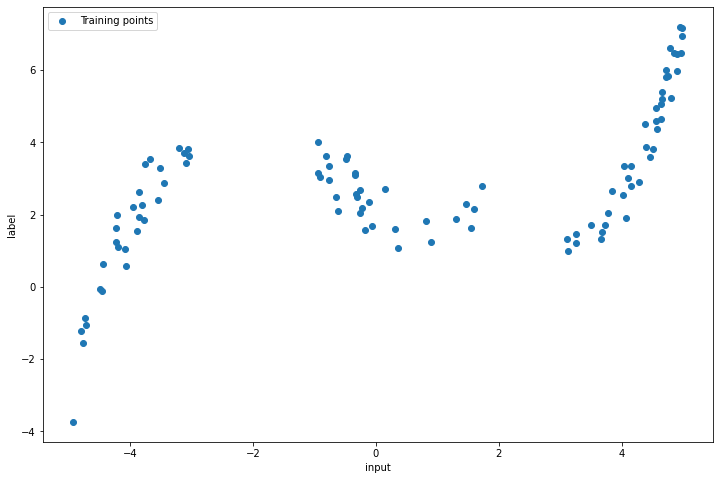

In [5]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, SequentialSampler, ConcatDataset
from torch.autograd import Variable
from sklearn.model_selection import KFold
from torchvision import transforms
from tqdm import tqdm   
from scipy.stats import loguniform 
from IPython.display import clear_output


#set seed for reproducibility
seed = 753
np.random.seed(seed)
torch.manual_seed(seed)

#Use as "hyper-hyper"param
batch_size = 20
n_folds = 5
sets_param_to_test = 500

# Check if a cuda GPU is available and eventually select it
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU available")
else:
  device = torch.device("cpu")
  print("GPU NOT available")

GPU NOT available


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
#This class has been implemented even though in this homework will note be used
#since data is too few, and we make use of k-fold CV.
class EarlyStopping:
    '''
    This class monitors whether a metrics does not improve over some
    number of epochs, and eventually stop the training
    '''

    def __init__(self, patience = 10, delta = 1e-5, path = "checkpoint.torch", verbose = False ):
        '''
        patience : how many iterations to wait after last improvement (default: 10)
        delta    : the minimum improvement one might consider (default: 1e-5)
        path     : where to save the best model so far (default: "checkpoint.torch")
        verbose  : whether to print some logs (eventual improvements (default: False))
        '''

        self.patience = patience
        self.counter  = 0
        self.delta    = delta
        self.verbose = verbose
        self.path    = path

        self.metrics_min = np.Inf
        self.early_stop  = False
        self.best_score  = None

    def __call__(self, metrics, model):
        actual_score = -metrics

        #this occurs at the first time step
        if self.best_score is None:
            self.best_score = actual_score 
            self.save_checkpoint(metrics, model)

        #if there is already a best score and no improvement
        elif actual_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        #if there is improvement, then restart the counter
        else:
            self.best_score = actual_score
            self.save_checkpoint(metrics, model)
            self.counter = 0
    
    def save_checkpoint(self, metrics, model):
        '''
        Save as a checkpoint the model when the metrics decrease
        '''
        if self.verbose:
            print("Actual metrics has decreased: ", self.metrics_min , " ---> ", metrics ,)
        torch.save(model.state_dict(), self.path)
        self.metrics_min = metrics


In [8]:
class Network(nn.Module):
    def __init__(self, Ni: int, Nh1: int, Nh2: int, No: int, 
                drop1 = 0. , drop2= 0.):
        '''
        Constructor that builds a Neural Network with 2 hidden layers
        and accepts the following parameters:
        Ni  (int) : input size
        Nh1 (int) : number of units in first hidden layer
        Nh2 (int) : number of units in second hidden layer
        No  (int) : output size
        drop1 (float) : probability of dropout first hidden layer
        drop2 (float) : probability of dropout second hidden layer
        '''
        super().__init__()

        #Network architecture related code
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        
        #Activation function related code 
        self.act = nn.ReLU()

        #Dropout related code
        self.drop1 = nn.Dropout(p = drop1)
        self.drop2 = nn.Dropout(p = drop2)

        #print("Network initialized!")


    def forward(self, x, additional_out=False):
        #first hidden layer related code
        x1 = self.act(self.fc1(x))
        x1 = self.drop1(x1)
        #second hidden layer related code
        x2 = self.act(self.fc2(x1))
        x2 = self.drop2(x2)
        #output layer
        out = self.out(x2)

        #if requested, return as second output activations of 1st, 2nd hidden layers
        if (additional_out):
            return out, [x1, x2] 
        
        return out

    def train_epoch(self, train_data_loader, loss_function, optimizer, device):
        '''
        Train the network (self) using as input eventual batches from train_data_loader,
        having chosen the loss_function and the optimizer
        it returns:
        - the mean loss over batches
        - the standard deviation loss over batches
        '''
        #enable training mode
        self.train()
        ### TRAIN
        train_loss = []
        for i_batch, sample_batched in enumerate(train_data_loader):

            #divide the batch into values and labels
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            #Forward pass
            out = self.forward(x_batch)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Backpropagation
            self.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss_mean = np.array(train_loss).sum()/len(train_data_loader)
        train_loss_std  = np.std(train_loss)

        return train_loss_mean, train_loss_std


    def eval_epoch(self, eval_data_loader, loss_function, optimizer, device):
        '''
        Evaulate the performance of network (self)
        using as input the validation set,
        having chosen the loss_function and the optimizer
        it returns:
        - the mean loss over batches
        - the standard deviation loss over batches
        '''
        #enable training mode
        self.eval()
        val_loss = []
        
        with torch.no_grad(): # Disable gradient tracking
            for i_batch, sample_batched in enumerate(eval_data_loader):
                #divide the batch into values and labels
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                #Forward pass
                out = self.forward(x_batch)

                # Compute loss
                loss = loss_function(out, label_batch)
                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

        # Save average val loss
        val_loss_mean = np.array(val_loss).sum()/len(eval_data_loader)
        val_loss_std  = np.std(val_loss)

        return val_loss_mean, val_loss_std

    #training WITHOUT early stopping
    def fit(self, train_data, val_data, params_dict, loss_fn, plot_flag = False):
        train_loss_means = []
        val_loss_means = []

        train_loss_std = []
        val_loss_std = []

        optimizer = params_dict.get('optimizer')
        device = params_dict.get('device')

        for epoch in tqdm(range(params_dict.get('n_epochs'))):
            loss_mean, loss_std =  self.train_epoch(train_data, loss_fn, optimizer, device)
            train_loss_means.append(loss_mean)
            train_loss_std.append(loss_std)

            loss_mean, loss_std =  self.eval_epoch(val_data, loss_fn, optimizer, device)
            val_loss_means.append(loss_mean)
            val_loss_std.append(loss_std)

        train_metrics = np.array([np.array(train_loss_means), np.array(train_loss_std)])
        val_metrics = np.array([np.array(val_loss_means), np.array(val_loss_std)])

        if (plot_flag):
            plt.figure(figsize = (8,6))
            plt.plot(train_metrics[0,:], label = 'train')
            plt.plot(val_metrics[0,:], label = 'test')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss vs epochs')
            plt.legend()
            plt.show()

        return train_metrics, val_metrics

    #training WITH early stopping
    def fit_early_stop(self, train_data, val_data, params_dict, loss_fn,
            early_stop_flag = False, patience = 10, verbose = False):
        train_loss_means = []
        val_loss_means = []

        train_loss_std = []
        val_loss_std = []

        optimizer = params_dict.get('optimizer')
        device = params_dict.get('device')
        
        #train with early stopping 
        if early_stop_flag: 
            early_stop = EarlyStopping(patience, verbose = verbose)

        for epoch in tqdm(range(params_dict.get('n_epochs'))):
            loss_mean, loss_std =  self.train_epoch(train_data, loss_fn, optimizer, device)
            train_loss_means.append(loss_mean)
            train_loss_std.append(loss_std)

            loss_mean, loss_std =  self.eval_epoch(val_data, loss_fn, optimizer, device)
            val_loss_means.append(loss_mean)
            val_loss_std.append(loss_std)

            #use early stop if the flag is set to True
            if early_stop_flag:
                early_stop(loss_mean, self)
                if early_stop.early_stop:
                    print("Loss has not increased. Early stopping...")
                    break

        train_metrics = np.array([np.array(train_loss_means), np.array(train_loss_std)])
        val_metrics = np.array([np.array(val_loss_means), np.array(val_loss_std)])

        return train_metrics, val_metrics
    
    def predict(self, data_input, device):
        '''
        Compute an array of predicted labels given input data
        '''
        #set evaluation mode
        self.eval()
        predictions_list = []

        #disable gradient computing/tracking
        with torch.no_grad():
            for i_batch, sample_batched in enumerate(data_input):
                x_batch = sample_batched[0].to(device) 
                #Forward pass
                out = self.forward(x_batch)
                outputs = out.cpu().numpy()
                predictions_list.append(outputs)

        return np.array(predictions_list)

    #save the network state onto a path passed as input
    def save_net(self, path: str):
        torch.save( self.state_dict(), path )
    
    #retrieve the network state from a path passed as input
    def load_net(self, path: str):
        self.load_state_dict( torch.load(path) )

In [9]:
class CsvDataset(Dataset):

  def __init__(self, csv_file: str, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    self.data = pd.read_csv(csv_file)
    self.cols = list(self.data.columns)

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.data)

  def __getitem__(self, idx):
    # Our sample constitutes of two elements contained in a tuple:
    # first -> x value ('input')
    # second -> y value ('label')
    sample = (self.data.iloc[idx][self.cols[0]], self.data.iloc[idx][self.cols[1]])
    if self.transform:
        sample = self.transform(sample)
    return sample

In [10]:
class ToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor([x]).float(),
                torch.Tensor([y]).float())

# Example Network, to see everything works smoothly

In [11]:
# Define the loss function
regression_loss = nn.MSELoss()

# Import train and test datasets and convert elements to tensors
train_dataset = CsvDataset('regression_dataset/train_data.csv', transform = ToTensor())
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform = ToTensor())

# Check whether everything is uploaded correctly
rand_idx = np.random.randint(len(train_dataset))
print("Total training points", len(train_dataset))
print("A random training point is ('input', 'label'):   ", train_dataset[rand_idx])

Total training points 100
A random training point is ('input', 'label'):    (tensor([4.9775]), tensor([6.9523]))


In [12]:
#Instantiate the network
My_Network = Network(1,25,50,1, 0.2, 0.2)
My_Network.to(device)

Network(
  (fc1): Linear(in_features=1, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=1, bias=True)
  (act): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
)

In [13]:
#choose an optimizer with a given learning rate by chance
trial_optimizer = optim.Adam(My_Network.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

params = dict({'optimizer': trial_optimizer,
               'n_epochs': 250,
               'device': device})

train, test = My_Network.fit_early_stop(train_dataset, test_dataset, 
                             params, loss_function, 
                             early_stop_flag = True,
                             patience = 30,
                             verbose = True,
                             )

  0% 1/250 [00:00<01:01,  4.05it/s]

Actual metrics has decreased:  inf  --->  3.918883


  1% 2/250 [00:00<01:02,  3.95it/s]

Actual metrics has decreased:  3.918883  --->  3.638877


  1% 3/250 [00:00<00:58,  4.19it/s]

Actual metrics has decreased:  3.638877  --->  3.5746534


  2% 4/250 [00:00<01:00,  4.07it/s]

Actual metrics has decreased:  3.5746534  --->  3.499889


  2% 5/250 [00:01<00:57,  4.25it/s]

Actual metrics has decreased:  3.499889  --->  3.4821024


  2% 6/250 [00:01<00:57,  4.25it/s]

Actual metrics has decreased:  3.4821024  --->  3.3660343


  4% 9/250 [00:02<00:52,  4.56it/s]

Actual metrics has decreased:  3.3660343  --->  3.2817993
Actual metrics has decreased:  3.2817993  --->  3.2263525


  4% 10/250 [00:02<00:52,  4.55it/s]

Actual metrics has decreased:  3.2263525  --->  3.1165469


  4% 11/250 [00:02<00:55,  4.29it/s]

Actual metrics has decreased:  3.1165469  --->  3.012699


  5% 12/250 [00:02<00:54,  4.39it/s]

Actual metrics has decreased:  3.012699  --->  2.9670923
Actual metrics has decreased:  2.9670923  --->  2.8623374


  6% 15/250 [00:03<00:48,  4.80it/s]

Actual metrics has decreased:  2.8623374  --->  2.7605813
Actual metrics has decreased:  2.7605813  --->  2.7376938


  7% 17/250 [00:03<00:46,  5.03it/s]

Actual metrics has decreased:  2.7376938  --->  2.6773858
Actual metrics has decreased:  2.6773858  --->  2.5942392


  8% 20/250 [00:04<00:43,  5.25it/s]

Actual metrics has decreased:  2.5942392  --->  2.4925163
Actual metrics has decreased:  2.4925163  --->  2.4339073


  9% 23/250 [00:04<00:44,  5.08it/s]

Actual metrics has decreased:  2.4339073  --->  2.4200737
Actual metrics has decreased:  2.4200737  --->  2.31911


 10% 25/250 [00:05<00:42,  5.26it/s]

Actual metrics has decreased:  2.31911  --->  2.2139344


 12% 30/250 [00:06<00:40,  5.41it/s]

Actual metrics has decreased:  2.2139344  --->  2.180029
Actual metrics has decreased:  2.180029  --->  2.1317472


 13% 32/250 [00:06<00:38,  5.68it/s]

Actual metrics has decreased:  2.1317472  --->  2.0443711


 14% 34/250 [00:07<00:39,  5.47it/s]

Actual metrics has decreased:  2.0443711  --->  1.9695915


 14% 36/250 [00:07<00:38,  5.50it/s]

Actual metrics has decreased:  1.9695915  --->  1.9435141
Actual metrics has decreased:  1.9435141  --->  1.9258945


 15% 37/250 [00:07<00:41,  5.10it/s]

Actual metrics has decreased:  1.9258945  --->  1.8804113


 16% 39/250 [00:08<00:40,  5.17it/s]

Actual metrics has decreased:  1.8804113  --->  1.8221244


 16% 41/250 [00:08<00:40,  5.16it/s]

Actual metrics has decreased:  1.8221244  --->  1.7924931
Actual metrics has decreased:  1.7924931  --->  1.7159767


 18% 44/250 [00:08<00:38,  5.39it/s]

Actual metrics has decreased:  1.7159767  --->  1.7074656
Actual metrics has decreased:  1.7074656  --->  1.7001984


 19% 47/250 [00:09<00:34,  5.91it/s]

Actual metrics has decreased:  1.7001984  --->  1.665712
Actual metrics has decreased:  1.665712  --->  1.6115522


 20% 49/250 [00:09<00:34,  5.84it/s]

Actual metrics has decreased:  1.6115522  --->  1.5739895
Actual metrics has decreased:  1.5739895  --->  1.5593435


 20% 51/250 [00:10<00:34,  5.85it/s]

Actual metrics has decreased:  1.5593435  --->  1.4997886
Actual metrics has decreased:  1.4997886  --->  1.4882596


 21% 53/250 [00:10<00:34,  5.66it/s]

Actual metrics has decreased:  1.4882596  --->  1.4645543
Actual metrics has decreased:  1.4645543  --->  1.4570701


 22% 55/250 [00:10<00:33,  5.76it/s]

Actual metrics has decreased:  1.4570701  --->  1.3594844
Actual metrics has decreased:  1.3594844  --->  1.3031234


 23% 58/250 [00:11<00:31,  6.07it/s]

Actual metrics has decreased:  1.3031234  --->  1.2560647


 24% 61/250 [00:11<00:31,  6.03it/s]

Actual metrics has decreased:  1.2560647  --->  1.2512004
Actual metrics has decreased:  1.2512004  --->  1.216946


 25% 62/250 [00:11<00:32,  5.85it/s]

Actual metrics has decreased:  1.216946  --->  1.1815776


 26% 64/250 [00:12<00:34,  5.42it/s]

Actual metrics has decreased:  1.1815776  --->  1.1456568


 26% 66/250 [00:12<00:31,  5.80it/s]

Actual metrics has decreased:  1.1456568  --->  1.1152174
Actual metrics has decreased:  1.1152174  --->  1.0988684


 27% 68/250 [00:13<00:31,  5.85it/s]

Actual metrics has decreased:  1.0988684  --->  1.0756017
Actual metrics has decreased:  1.0756017  --->  1.0010042


 28% 70/250 [00:13<00:29,  6.06it/s]

Actual metrics has decreased:  1.0010042  --->  0.98385435
Actual metrics has decreased:  0.98385435  --->  0.9634062


 30% 75/250 [00:14<00:28,  6.05it/s]

Actual metrics has decreased:  0.9634062  --->  0.8668314
Actual metrics has decreased:  0.8668314  --->  0.8595567


 32% 79/250 [00:14<00:27,  6.27it/s]

Actual metrics has decreased:  0.8595567  --->  0.8076532
Actual metrics has decreased:  0.8076532  --->  0.7382834


 34% 84/250 [00:15<00:26,  6.29it/s]

Actual metrics has decreased:  0.7382834  --->  0.7281966


 35% 87/250 [00:16<00:25,  6.38it/s]

Actual metrics has decreased:  0.7281966  --->  0.71696115
Actual metrics has decreased:  0.71696115  --->  0.6989855


 36% 89/250 [00:16<00:25,  6.30it/s]

Actual metrics has decreased:  0.6989855  --->  0.6060241


 37% 93/250 [00:17<00:24,  6.33it/s]

Actual metrics has decreased:  0.6060241  --->  0.5725185


 38% 95/250 [00:17<00:24,  6.29it/s]

Actual metrics has decreased:  0.5725185  --->  0.56343144
Actual metrics has decreased:  0.56343144  --->  0.54140425


 39% 98/250 [00:17<00:24,  6.28it/s]

Actual metrics has decreased:  0.54140425  --->  0.4737279


 41% 103/250 [00:18<00:23,  6.31it/s]

Actual metrics has decreased:  0.4737279  --->  0.4684409
Actual metrics has decreased:  0.4684409  --->  0.45849946


 42% 106/250 [00:19<00:22,  6.30it/s]

Actual metrics has decreased:  0.45849946  --->  0.45646596


 44% 109/250 [00:19<00:22,  6.27it/s]

Actual metrics has decreased:  0.45646596  --->  0.38059738


 45% 113/250 [00:20<00:21,  6.31it/s]

Actual metrics has decreased:  0.38059738  --->  0.36917073


 47% 117/250 [00:20<00:20,  6.37it/s]

Actual metrics has decreased:  0.36917073  --->  0.3679931


 58% 145/250 [00:25<00:18,  5.70it/s]

Loss has not increased. Early stopping...


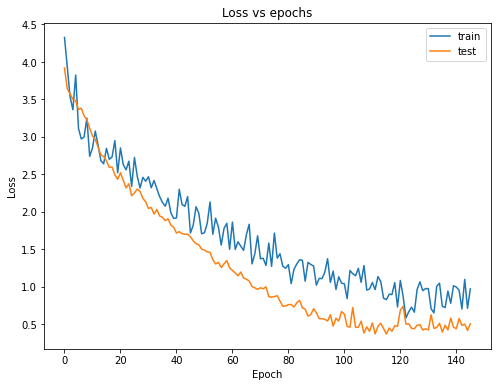

In [14]:
#manual plotting
plt.figure(figsize = (8,6))
plt.plot(train[0,:], label = 'train')
plt.plot(test[0,:], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.legend()
plt.show()

# Grid Search Validation

In order to best estimate the hyperparameters, we proceed to use a GridSearch CV over k=5 folds. 

In [15]:
#reset parameters to avoid weights leakage
#source https://androidkt.com/pytorch-k-fold-cross-validation-using-dataloader-and-sklearn/
def reset_weights(model):
    if isinstance(model, nn.Linear):
        model.reset_parameters()

Let us now sample a grid of parameters from which we might want to sample from

In [16]:
from scipy.stats import loguniform

parameters_dict = {
    'dropout1'   : np.random.uniform(0, 0.4, 100),
    'dropout2'   : np.random.uniform(0, 0.6, 100),
    'n_epochs'   : [100, 200, 300, 500],
    'Nh1'        : [20, 50, 75, 100],
    'Nh2'        : [50, 100, 150],
    'optimizer'  : ['adam', 'sgd', 'adagrad'],
    'learn_rate' : loguniform.rvs(1e-5, 1e-2, size = 100),
    'weight_dec' : loguniform.rvs(1e-3, 1e0, size = 100), #acts similarly to L2 norm
    'device'     : [device]
}

In [17]:
#sample a single set of parameters out
def sample_set_params(params_urn):
  drawn = {}
  for param in params_urn.keys():
    drawn[param] = np.random.choice( params_urn.get(param) )

  return drawn

sample_set_params(parameters_dict)

{'dropout1': 0.13284891490180112,
 'dropout2': 0.46765774446238134,
 'n_epochs': 200,
 'Nh1': 20,
 'Nh2': 100,
 'optimizer': 'adagrad',
 'learn_rate': 1.3432277232397257e-05,
 'weight_dec': 0.009251800344374181,
 'device': device(type='cpu')}

In [18]:
def get_correct_optimizer(model, params_dict):
    learn_r = params_dict.get('learn_rate')
    w_dec   = params_dict.get('weight_dec')
    
    #instantiate the correct optimizer
    if params_dict.get('optimizer') == 'sgd':
        optimizer = optim.SGD(
            model.parameters(),
            lr = learn_r,
            weight_decay = w_dec,
            momentum = 0.9
            )

    elif params_dict.get('optimizer') == 'adam':
        optimizer = optim.Adam(
        model.parameters(),
        lr = learn_r,
        weight_decay = w_dec,
        )

    elif params_dict.get('optimizer') == 'adagrad':
        optimizer = optim.Adagrad(
        model.parameters(),
        lr = learn_r,
        weight_decay = w_dec
        )

    return optimizer

In [19]:
def CV_k_fold_random(dataset, params_grid, n_folds, iterations):
    '''
    This functions tries a given number of set of parameters, in order
    to find the optimal set of parameters which reaches the least validation loss
    Since data is few, the search is done after splitting the training data into
    a certain number of folds (K-FOLD cross validation)
    INPUTS:
    - dataset     : training set dataloader to split in k folds
    - params_grid : a dictionary with the parameters one draws from
    - n_folds     : number of manifolds one splits the dataset into
    - iterations  : number of set of parameters to be tested

    OUTPUT:
    A dictionary containing: 
    - the set of parameters chosen
    - training loss for every epoch
    - validation loss for every epoch
    '''

    output_dict = {}
    parameters_list     = []
    train_loss_log      = []
    validation_loss_log = []

    #the loss remains the same due to the nature of the problem
    loss = nn.MSELoss()

    for iterat in range(iterations):
        #"draw" a model
        actual_params = sample_set_params(params_grid)
        parameters_list.append(actual_params)

        #prepare for hyperparams chosen
        N_in, N_out = 1, 1
        Nh1 = actual_params.get('Nh1')
        Nh2 = actual_params.get('Nh2')
        dropout1 = actual_params.get('dropout1')
        dropout2 = actual_params.get('dropout2')
        learn_r  = actual_params.get('learn_rate')
        n_epochs = actual_params.get('n_epochs')
        w_dec    = actual_params.get('weight_dec')

        #prepare the folds for CV arrays to store the each fold result
        #it is faster to compute averages
        kfold = KFold(n_folds, shuffle=True)
        tra_loss_array = np.zeros((n_folds, n_epochs))
        val_loss_array = np.zeros((n_folds, n_epochs))

        #start the k-fold CV
        for fold, (train_index, val_index) in enumerate(kfold.split(dataset)):
            print("\n############## MODEL ", iterat+1, "/", iterations , "##################### " )
            print("############## FOLD  ", fold+1, "/", n_folds , "   ##################### \n" )
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
            valid_subsampler = torch.utils.data.SubsetRandomSampler(val_index)
        
            trainloader = torch.utils.data.DataLoader(
                            dataset, 
                            batch_size = batch_size,
                            sampler = train_subsampler)
            valloader = torch.utils.data.DataLoader(
                            dataset,
                            batch_size = batch_size, 
                            sampler = valid_subsampler)


            #create new network with given parameters and reset weights
            network = Network(N_in, Nh1, Nh2, N_out, dropout1, dropout2).to(device)
            network.apply(reset_weights)

            optimizer = get_correct_optimizer(network, actual_params)

            #instantiate this dummy dict due to "fit" method implementation
            dummy_dict = {'optimizer': optimizer, 'n_epochs': n_epochs, 'device': device}
            #do the job -> training and validation over a single fold
            train_loss, val_loss = network.fit(trainloader, valloader,
                                                dummy_dict , loss, False)
                
            #fold is an index that denotes the fold we are dealing with
            tra_loss_array[fold, 0:] = train_loss[0,:]
            val_loss_array[fold, 0:] = val_loss[0,:]
            clear_output(wait=False)
            del network 

        #compute the average over the folds
        train_loss_log.append( np.mean(np.array(tra_loss_array), axis=0) )
        validation_loss_log.append( np.mean(np.array(val_loss_array), axis=0))

    return  parameters_list, train_loss_log, validation_loss_log 

In [20]:
pars_list, tr_log, val_log = CV_k_fold_random(train_dataset, parameters_dict, n_folds, sets_param_to_test)

In [63]:
results = pd.DataFrame([pars_list, tr_log, val_log]).T
results.columns = ['params', 'training_loss', 'val_loss']
results['av_validation_loss'] = results.val_loss.apply(lambda x: np.mean(x[-5:]))
results = results.sort_values('av_validation_loss').reset_index(drop = True)
results.to_csv('results_regression.csv')
results

,params,training_loss,val_loss,av_validation_loss
0,"{'dropout1': 0.006163578008803939, 'dropout2':...","[10.17362995147705, 5.205695390701294, 3.69070...","[6.067436408996582, 3.6484410762786865, 3.3146...",0.344036
1,"{'dropout1': 0.01920781705366044, 'dropout2': ...","[8.832377910614014, 4.795460653305054, 3.64059...","[5.945719814300537, 3.625753307342529, 3.25719...",0.363790
2,"{'dropout1': 0.04960606162274792, 'dropout2': ...","[9.592105484008789, 5.811144638061523, 4.01585...","[7.43076524734497, 4.878793525695801, 3.703682...",0.365349
3,"{'dropout1': 0.04948966542713969, 'dropout2': ...","[7.087419128417968, 4.040212249755859, 3.18971...","[4.782381629943847, 3.168409729003906, 3.30592...",0.366249
4,"{'dropout1': 0.2753757689211055, 'dropout2': 0...","[6.591071510314942, 4.392033386230469, 3.33938...","[5.213953495025635, 3.633195996284485, 2.79650...",0.387938
...,...,...,...,...
495,"{'dropout1': 0.09011934153750976, 'dropout2': ...","[12.203193664550781, 12.041943550109863, 12.05...","[12.152721691131593, 12.14150791168213, 12.132...",11.902441
496,"{'dropout1': 0.3833383444554151, 'dropout2': 0...","[12.74655818939209, 12.753242301940919, 12.540...","[12.756248664855956, 12.720134162902832, 12.69...",11.988948
497,"{'dropout1': 0.36422612119098485, 'dropout2': ...","[13.752826499938966, 13.964165306091308, 14.28...","[13.297317123413086, 13.281270217895507, 13.26...",12.486159
498,"{'dropout1': 0.09783263453517771, 'dropout2': ...","[14.220297050476074, 13.966296005249024, 14.12...","[13.61349925994873, 13.600553894042969, 13.590...",12.935342


In [64]:
print("Best set of parameters is: ------>" )
opt_set = results.params[0]
print(opt_set)

Best set of parameters is: ------>
{'dropout1': 0.006163578008803939, 'dropout2': 0.35993588775629654, 'n_epochs': 300, 'Nh1': 20, 'Nh2': 150, 'optimizer': 'adam', 'learn_rate': 0.003910926702853117, 'weight_dec': 0.0014722337879186907, 'device': device(type='cpu')}


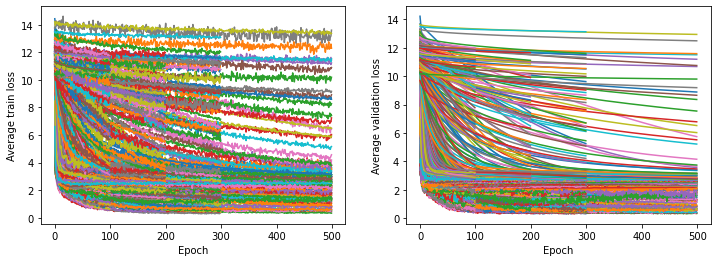

In [68]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
for i in results.iterrows():
    ax[0].plot(i[1].training_loss)
    ax[1].plot(i[1].val_loss)
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Average train loss')
ax[1].set_ylabel('Average validation loss')

plt.show()

# Train the network with best hyper-params

In [42]:
#prepare for hyperparams chosen
N_in, N_out = 1, 1
Nh1 = opt_set.get('Nh1')
Nh2 = opt_set.get('Nh2')
dropout1 = opt_set.get('dropout1')
dropout2 = opt_set.get('dropout2')
learn_r  = opt_set.get('learn_rate')
n_epochs = opt_set.get('n_epochs')
w_dec    = opt_set.get('weight_dec')

In [43]:
#instantiate the best network
best_network = Network(N_in, Nh1, Nh2, N_out, dropout1, dropout2).to(device)
best_network.apply(reset_weights)
optimizer = get_correct_optimizer(best_network, opt_set)
#instantiate this dummy dict due to "fit" method implementation
dummy_dict = {'optimizer': optimizer, 'n_epochs': n_epochs, 'device': device} 

train, test = best_network.fit(train_dataset, test_dataset, dummy_dict, loss_function)

100% 300/300 [00:50<00:00,  5.92it/s]


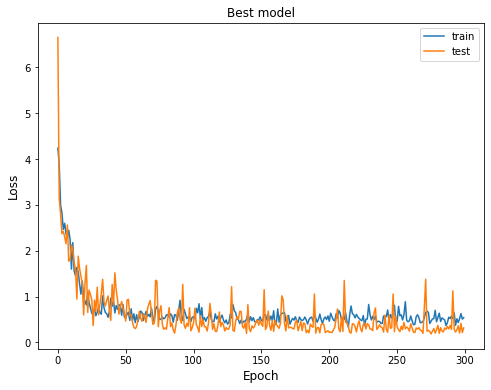

In [44]:
#manual plotting
plt.figure(figsize = (8,6))
plt.plot(train[0,:], label = 'train')
plt.plot(test[0,:], label = 'test')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Best model', fontsize = 12)
plt.legend()
plt.show()

In [74]:
#save the network and the optimizer
best_params_dict = best_network.state_dict()
torch.save(best_params_dict, 'best_net_params_regression.torch')
# save the optimizer
torch.save(optimizer.state_dict(), 'best_net_optimizer_regression.torch')

# Analyze predictions

In [55]:
x_train = torch.unsqueeze(torch.tensor(train_df.input), dim=1).float()
x = Variable(x_train).to(device)

y_train = torch.unsqueeze(torch.tensor(train_df.label), dim=1).float()
y = Variable(y_train).to(device)

#predicted function
x_pred = torch.linspace(-6, +6, 1000).to(device).unsqueeze(-1)

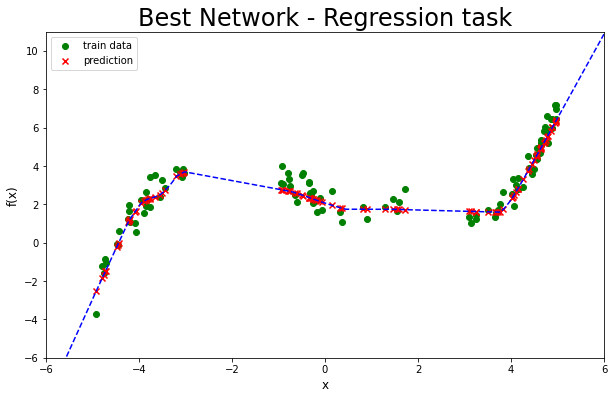

In [56]:
fig, ax = plt.subplots(figsize=(10,6))
plt.cla()
ax.set_title('Best Network - Regression task', fontsize = 24)
ax.set_xlabel('x'   , fontsize = 12)
ax.set_ylabel('f(x)', fontsize = 12)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 11)
ax.scatter(train_df.input, train_df.label, color = 'g', label = "train data")

#feed the network with x and save the output
prediction = best_network(x)     
# Network output
with torch.no_grad():
    y_pred = best_network(x_pred)

ax.plot(x_pred.squeeze().cpu().numpy(), y_pred.squeeze().cpu().numpy(), 'b--')
ax.scatter(x.data.cpu().numpy(), prediction.data.cpu().numpy(), color = 'r', marker = 'x', label = "prediction")

plt.legend()
plt.savefig('best_net_fitting.png')
plt.show()

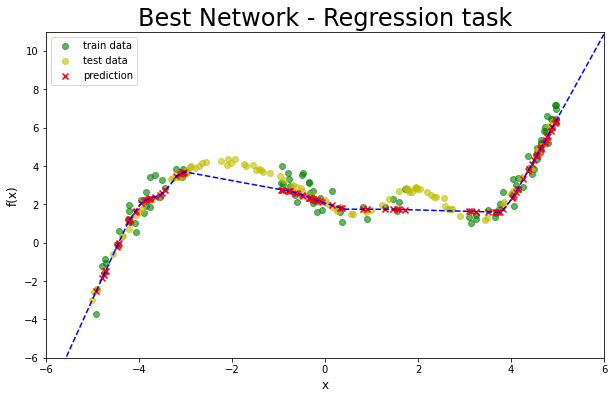

In [65]:
test_df = pd.read_csv('regression_dataset/test_data.csv')

fig, ax = plt.subplots(figsize=(10,6))
plt.cla()
ax.set_title('Best Network - Regression task', fontsize = 24)
ax.set_xlabel('x'   , fontsize = 12)
ax.set_ylabel('f(x)', fontsize = 12)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 11)
ax.scatter(train_df.input, train_df.label, color = 'g', label = "train data", alpha =.6)
ax.scatter(test_df.input, test_df.label, color = 'y', label = "test data", alpha =.6)

ax.plot(x_pred.squeeze().cpu().numpy(), y_pred.squeeze().cpu().numpy(), 'b--')
ax.scatter(x.data.cpu().numpy(), prediction.data.cpu().numpy(), color = 'r', marker = 'x', label = "prediction")

plt.legend()
plt.savefig('best_net_fitting.png')
plt.show()

# Inspect the weights

In [58]:
# First hidden layer
h1_weight = best_network.fc1.weight.data.cpu().numpy()
h1_bias   = best_network.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_weight = best_network.fc2.weight.data.cpu().numpy()
h2_bias   = best_network.fc2.bias.data.cpu().numpy()

# Output layer
out_weight = best_network.out.weight.data.cpu().numpy()
out_bias   = best_network.out.bias.data.cpu().numpy()

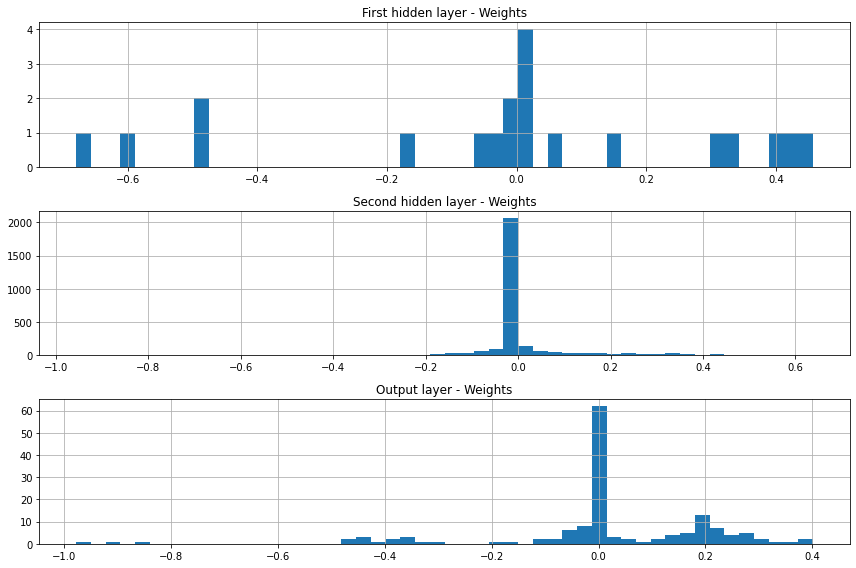

In [71]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_weight.flatten(), 50)
axs[0].set_title('First hidden layer - Weights')

axs[1].hist(h2_weight.flatten(), 50)
axs[1].set_title('Second hidden layer - Weights')

axs[2].hist(out_weight.flatten(), 50)
axs[2].set_title('Output layer - Weights')
[ax.grid() for ax in axs]
plt.savefig('weights.png')
plt.tight_layout()
plt.show()

# Inspect the activations 

In [60]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

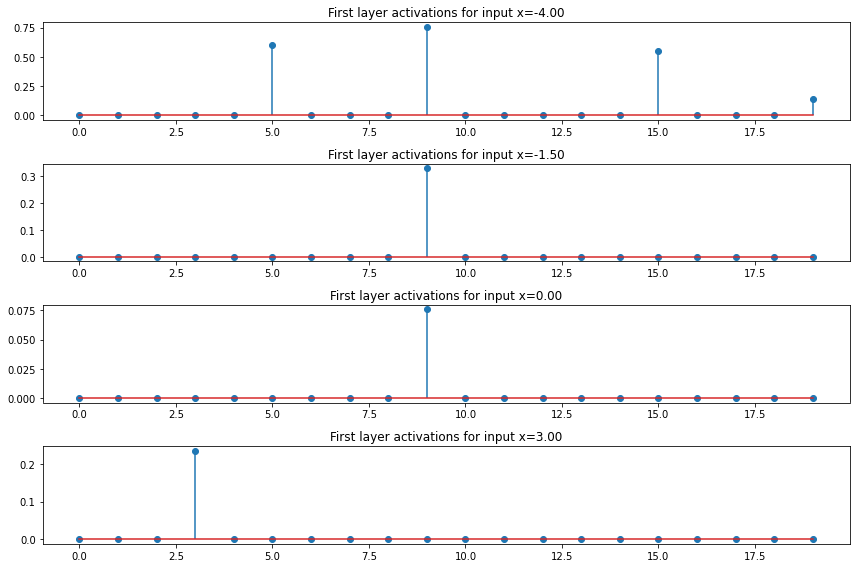

In [72]:
### Register hook  
hook_handle1 = best_network.fc1.register_forward_hook(get_activation)

### Analyze activations
best_network.to(device).eval()
inputs = [-4, -1.5, 0, 3]
inputs_list = [ torch.tensor([x]).float() for x in inputs]
outputs_list = []

with torch.no_grad():
    for input in inputs_list:
        temp_y = best_network(input.to(device))
        outputs_list.append(activation)

### Remove hook
hook_handle1.remove()

### Plot activations
tot_inputs = len(inputs_list)
fig, axs = plt.subplots(tot_inputs, 1, figsize=(12,8))
for i, output in enumerate(outputs_list): 
    axs[i].stem(output.cpu().numpy(), use_line_collection=True)
    axs[i].set_title('First layer activations for input x=%.2f' % inputs[i])
plt.savefig('activations_first.png')
plt.tight_layout()
plt.show()

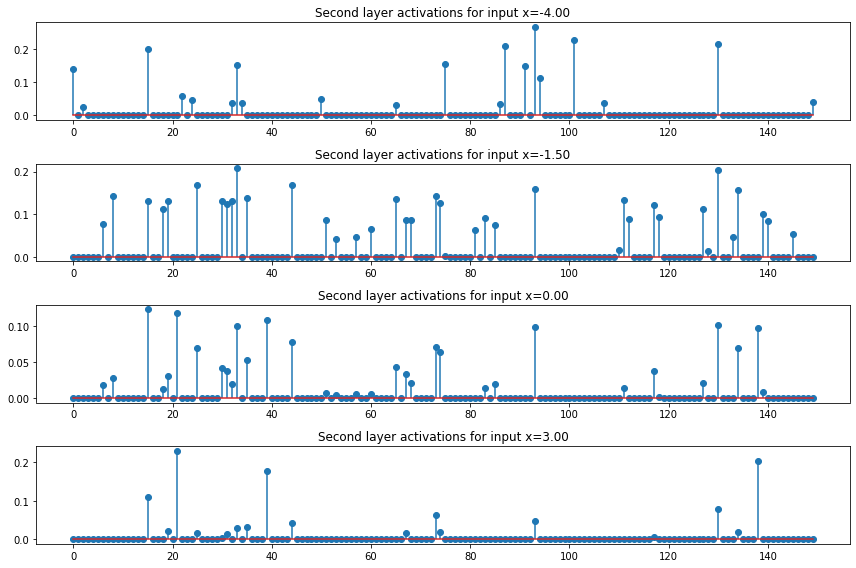

In [73]:
### Register hook  
hook_handle2 = best_network.fc2.register_forward_hook(get_activation)

### Analyze activations
best_network.to(device).eval()
inputs = [-4, -1.5, 0, 3]
inputs_list = [ torch.tensor([x]).float() for x in inputs]
outputs_list = []

with torch.no_grad():
    for input in inputs_list:
        temp_y = best_network(input.to(device))
        outputs_list.append(activation)

### Remove hook
hook_handle2.remove()

### Plot activations
tot_inputs = len(inputs_list)
fig, axs = plt.subplots(tot_inputs, 1, figsize=(12,8))
for i, input in enumerate(outputs_list): 
    axs[i].stem(input.cpu().numpy(), use_line_collection=True)
    axs[i].set_title('Second layer activations for input x=%.2f' % inputs[i])
plt.savefig('activations_second.png')
plt.tight_layout()
plt.show()